# Question clustering algorithm

Here I show how we can use a simple NLP algorithm to cluster questions within the same exercise to then produce key statistics for each of the clusters.

Briefly, the method consists of first cleaning the text for each of the questions, then converting these to vectors, and finally using Kmeans to cluster questions into sub-categories of subjects.

## Cleaning the text

For higher classification efficiency the text requires some pre-processing. Basic text processing includes removing capital letters, punctuations, numbers, over spaces, etc... We futher remove stop words (e.g. and, or,...), and perform lemmatization, including Part Of Speech (PoS) Tagging (e.g. plays => play, understanding => understand). For instance, the question,

> Understanding the relationship between pulmonary embolism and long COVID-19, and the consequences in patients with previous airway diseases.

becomes after text processing,

> understand relationship pulmonary embolism long covid consequence patient previous airway disease.

## Creating a dictionary

Once the text has been cleaned, we can create a dictionary. The dictionary contains all of the words used for the classification. In our case, I took every single words that I could find in the questions, therefore our dictionary contains 599 unique words.

## Word embedding

This step is key to the classification. Word embedding consists of transforming the questions into vectors so that they can be ingested by the classifier. As we are trying to cluster questions of the same exercise into different sub-subjects, the meaning of the words is key. Therefore, I use the GloVe 300 embedding, which is a pre-trained NLP algorithm which captures the meaning of the words. To do this, each word of the GloVe dictionary is replaced by a vector of length 300, and two words that have close meaning will lie close in the vector space, while two oposite words will be far apart (see https://nlp.stanford.edu/projects/glove/ for more details).

Therefore, for each of our questions, we convert the words into vectors of length 300, the entries of which correspond to the values given by the GloVe pre-trained NLP algorithm. The resulting matrix has a shape of (n_word x 300), where n_word is the number of words in the corresponding question.

The final step consists of averaging over the words in the question. Therefore each of the questions in our exercise is represented by a single vector of length 300 with entries that (hopefully!) have retained the general meaning of the question.

The figure below shows the 98 vectors of length 300 which represent each of the 98 questions of our exercise.

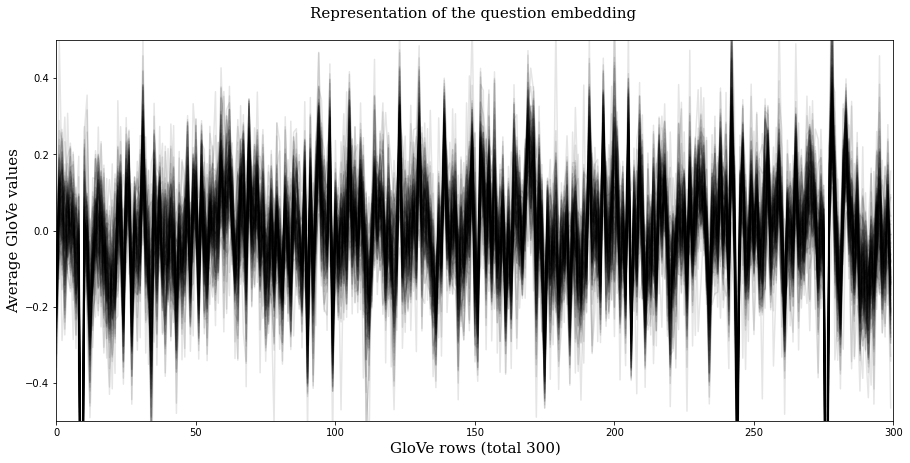

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.font_manager import FontProperties
font0 = FontProperties(family = 'serif', variant = 'small-caps', size = 15)

# load the mean vectors for each of the questions
embedding_means = np.array(np.loadtxt("./tmp/embeddings_mean.txt").reshape(98,300))

# Plot the embeddings
fig, axs = plt.subplots(figsize = (15, 7))
for embedded_question in embedding_means:
    axs.plot(embedded_question, 'k-', alpha = 0.1)

axs.set_xlabel('GloVe rows (total 300)', fontproperties = font0)
axs.set_ylabel('Average GloVe values', fontproperties = font0)
axs.set_xlim([0, 300])
axs.set_ylim([-0.5, 0.5])
axs.set_title('Representation of the question embedding \n', fontproperties = font0)
plt.show()

## Separating the questions into sub-subjects

Now that each of the questions of our exercise is represented by a single vector, we can group them by similarities in terms of their meanings. To do this we use a K-mean clustering algorithm which employs optimisation techniques on the distances between points to find clusters.

However, prior to run the K-mean clustering we must decide on how many subjects our questions need to be divided into. This is calculated using the Silhouette Coefficient metric, which provides the goodness of a clustering technique. Therefore, we use an iterative process to test several values for the number of clusters, and select that of with the best Silhouette coefficient.

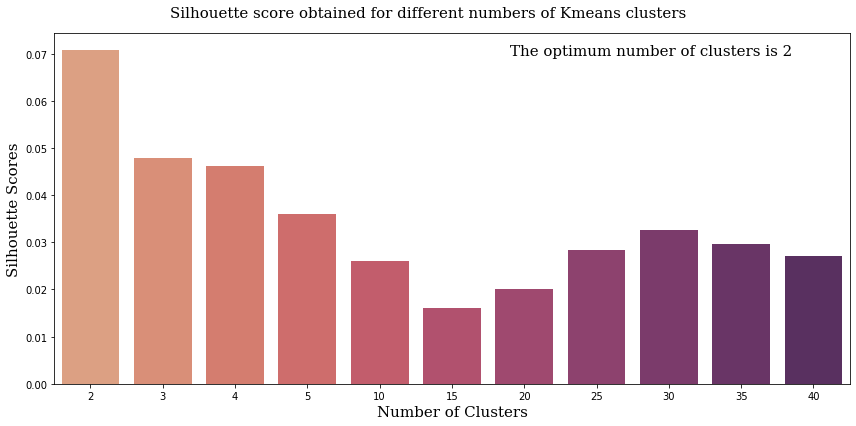

In [7]:
from sklearn import model_selection, cluster, decomposition, metrics
import seaborn as sns
import pandas as pd

n_clusters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40] # number of clusters considered
parameter_grid = model_selection.ParameterGrid({'n_clusters': n_clusters})
best_score = -1.
kmeans_model = cluster.KMeans(init = 'k-means++', n_init = 50)
silhouette_scores = []

# run Kmeans on all the different values of n_clusters
# and calculate the silhouette score
for p in parameter_grid:
    kmeans_model.set_params(**p)
    kmeans_model.fit(embedding_means)
    ss = metrics.silhouette_score(embedding_means, kmeans_model.labels_)
    silhouette_scores.append(ss)
    if ss > best_score:
        best_score = ss
        best_grid = p

# Optimum number of clusters
optimum_n_clusters = n_clusters[np.argmax(silhouette_scores)]

# Plot the silhouette score
df_silhouette = pd.DataFrame({'n_clusters': n_clusters, 'silhouette_scores': silhouette_scores})
fig, axs = plt.subplots(figsize = (12, 6))
sns.barplot(x = 'n_clusters', y = 'silhouette_scores', data=df_silhouette, errwidth = 0.3,
            palette = sns.color_palette("flare", len(n_clusters)))
axs.set_ylabel('Silhouette Scores', fontproperties = font0)
axs.set_xlabel('Number of Clusters', fontproperties = font0)
axs.text(0.75, 0.95,'The optimum number of clusters is {}'.format(optimum_n_clusters), 
         horizontalalignment='center', verticalalignment='center',
         transform = axs.transAxes, fontproperties = font0)
fig.suptitle('Silhouette score obtained for different numbers of Kmeans clusters', fontproperties = font0)
plt.tight_layout()
plt.show()

This figure shows the Silhouette scores of the K-means performed with a different number of clusters. The best score is returned for two clusters, meaning that, at most, there is potentially two sub-subjects in the questions.

## Preliminary results

In this section we fit the K-means to the questions with two clusters and explore some preliminary results.

### Visualising the two clusters

We have separated the questions into two clusters, each of which corresponds to a different subject (i.e. contains words with different meannings). To see these two clusters we employ a PCA analysis to reduce the parameter space from 300 dimensions (size of the embedding vectors), down to two.

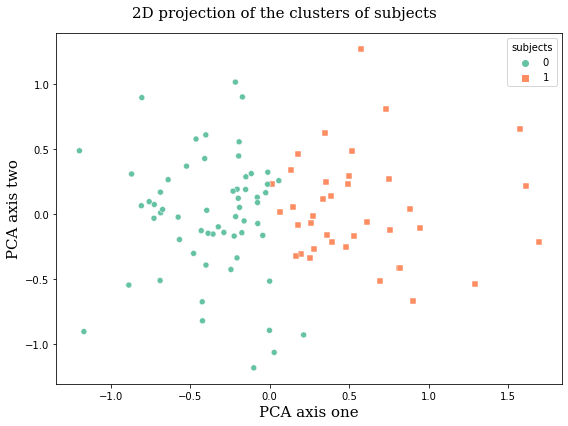

In [3]:
# fitting the KMeans
kmeans = cluster.KMeans(n_clusters=optimum_n_clusters, init = 'k-means++', n_init = 50)
kmeans.fit(embedding_means)

# Visualise the result of the Kmean using PCA to reduce dimensions to 2.
reduced_data = decomposition.PCA(n_components=2).fit_transform(embedding_means)
df_kmeans = pd.DataFrame({'x': np.array([x[0] for x in reduced_data]), 
                          'y': np.array([x[1] for x in reduced_data]),
                          'subjects': kmeans.labels_})

markers = ['o', 's']
fig, axs = plt.subplots(figsize = (8, 6))
sns.scatterplot(data=df_kmeans, x="x", y="y", hue="subjects", style="subjects",
                markers = markers, palette="Set2")
axs.set_xlabel('PCA axis one', fontproperties = font0)    
axs.set_ylabel('PCA axis two', fontproperties = font0)
fig.suptitle('2D projection of the clusters of subjects', fontproperties = font0)
plt.tight_layout()
plt.show()

We can clearly see the two clusters, which arises from the differences that we might have in the full set of questions. We stress that there is no clear divide between the two, suggesting that the differences are subtle. However, these have been designed in a 300 dimensions space, hence it might be difficult to correctly visualise them in a 2D space.

### Differences between the two subjects

To understand better the two clusters of questions, we plot the 10 most common words of each of the subjects.

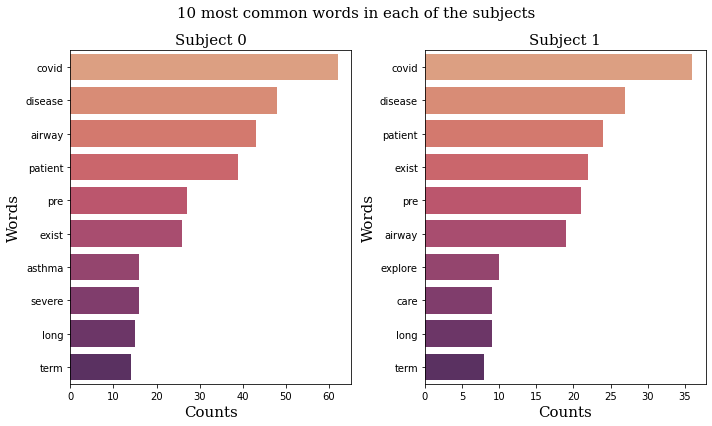

In [8]:
from collections import Counter

# Load the DF with the labels from the K-mean
df_master = pd.read_csv('./tmp/df_master.csv')
    
# plot the top 10 most common words in each of the subjects
n_subjects = len(df_master.groupby(by = 'kmeans_labels'))
n_words = 10 #Numbers of top words to look at
df_questions = df_master.drop_duplicates(subset = ['text_cleaned'])
most_common_words = df_questions.groupby(by = ['kmeans_labels'])['text_cleaned'].\
                    apply(lambda x: Counter(" ".join(x).split()).most_common(n_words)).\
                    reset_index().\
                    rename(columns = {'text_cleaned' : 'most_common_words'})

fig, axs = plt.subplots(1, n_subjects, figsize = (10, 6))
for i in range(0, n_subjects):
    m_c_w = [m_c_w_i[0] for m_c_w_i in most_common_words['most_common_words'][i]]
    nm_c_w = [m_c_w_i[1] for m_c_w_i in most_common_words['most_common_words'][i]]
    df_n_m_w = pd.DataFrame({'word': m_c_w, 'n_word': nm_c_w})
    sns.barplot(x = 'n_word', y = 'word', data=df_n_m_w, errwidth = 0.3,
                palette = sns.color_palette("flare", n_words), ax = axs[i],
                orient = 'h')
    axs[i].set_title('Subject {}'.format(i), fontproperties = font0)
    axs[i].set_xlabel('Counts', fontproperties = font0)
    axs[i].set_ylabel('Words', fontproperties = font0)

fig.suptitle('{} most common words in each of the subjects'.format(n_words), fontproperties = font0)
plt.tight_layout()
plt.show()

Both subjects seem to be related to the long-term effects of COVID in patients with pre-existing diseases. However, on the left-hand side, the subject seems to be more focused on Asthma. Presented like this, it is difficult to tell the differences between the two subjects.

Instead, we can test the importance of each of these most common words, and calculate how much they weight toward one or the other subject. To calculate the weights, we take the fraction they appear on the left-hand side and right-hand side subject, and substract one to the other. If the value is close to zero, it means that they equally weight toward both subjects. If the weight takes extreme values, it means that the corresponding word is heavily present in one subject and not the other.

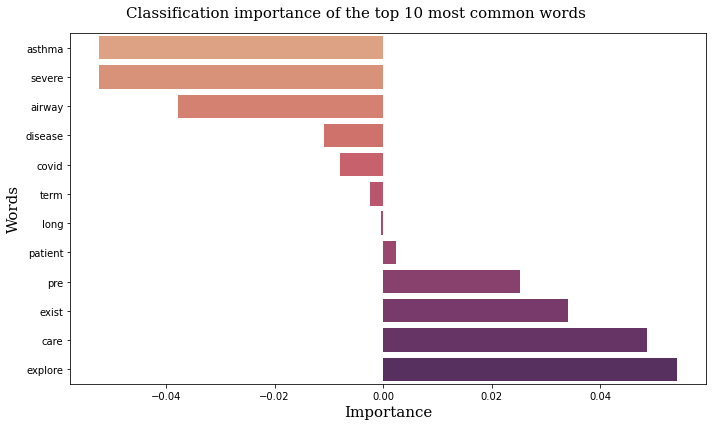

In [9]:
# Plot the importance of each of the most-common words
most_common_words_s1 = most_common_words['most_common_words'][0]
m_c_w_s1 = [m_c_w_i[0] for m_c_w_i in most_common_words_s1]
n_tot_s1 = np.sum([m_c_w_i[1] for m_c_w_i in most_common_words_s1])
frac_s1 = [m_c_w_i[1] for m_c_w_i in most_common_words_s1]/n_tot_s1

most_common_words_s2 = most_common_words['most_common_words'][1]
m_c_w_s2 = [m_c_w_i[0] for m_c_w_i in most_common_words_s2]
n_tot_s2 = np.sum([m_c_w_i[1] for m_c_w_i in most_common_words_s2])
frac_s2 = [m_c_w_i[1] for m_c_w_i in most_common_words_s2]/n_tot_s2

m_c_w = np.unique(m_c_w_s1 + m_c_w_s2)
frac_metric = []
for m_c_w_i in m_c_w:

    if m_c_w_i in m_c_w_s1:
        frac_s1_i = frac_s1[np.where(np.array(m_c_w_s1) == m_c_w_i)[0][0]]
    else:
        frac_s1_i = 0.

    if m_c_w_i in m_c_w_s2:
        frac_s2_i = frac_s2[np.where(np.array(m_c_w_s2) == m_c_w_i)[0][0]]
    else:
        frac_s2_i = 0.

    frac_metric.append((frac_s2_i - frac_s1_i))

sort_index = np.argsort(frac_metric)
frac_metric = np.array(frac_metric)[sort_index]
m_c_w = np.array(m_c_w)[sort_index]

df_mcw = pd.DataFrame({'mcw':m_c_w, 'frac':frac_metric})

fig, axs = plt.subplots(figsize = (10, 6))
sns.barplot(x = 'frac', y = 'mcw', data=df_mcw, errwidth = 0.3,
            palette = sns.color_palette("flare", len(df_mcw)), ax = axs,
            orient = 'h')

axs.set_xlabel('Importance', fontproperties = font0)
axs.set_ylabel('Words', fontproperties = font0)

fig.suptitle('Classification importance of the top {} most common words'.format(n_words), fontproperties = font0)
plt.tight_layout()
plt.show()

Looking at this figure, the common subject of the questions is clearly "patient with long-term COVID" since these words equally weight in both subjects. However, the "subject 0" (i.e. left-hand side) seems to be more related to investigating the connection with severe asthma, while the "subject 1" (i.e. right-hand side) seems to be more related to exploring pre-existing healthcare conditions.

Finally, we look at the average results of both subjects in terms of scoring to see whether one subject has performed better than the other.

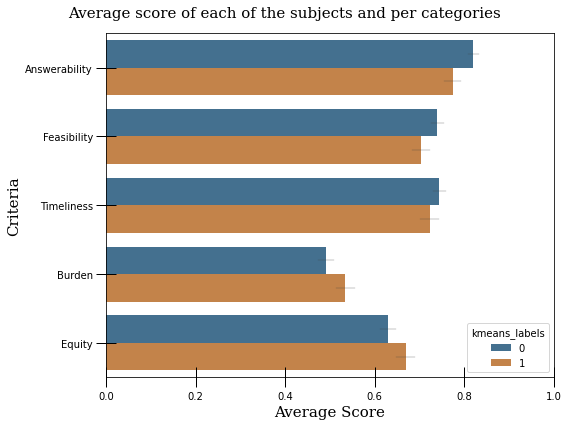

In [10]:
# Plot the average score in each of the subjects
fig, axs = plt.subplots(figsize = (8, 6))
sns.barplot(x = 'score', y = 'name', hue = 'kmeans_labels', data=df_master,
            orient = 'h', saturation = 0.5, errwidth = 0.3)
axs.set_ylabel('Criteria', fontproperties = font0)
axs.set_xlabel('Average Score', fontproperties = font0)
axs.tick_params(axis='both', labelcolor='k', labelsize = 10,
                width = 1, size = 20, which = 'major', direction = 'inout')
axs.tick_params(axis='both', width = 1, size = 10, which = 'minor',
                direction = 'inout')
axs.set_xlim([0., 1.])
fig.suptitle('Average score of each of the subjects and per categories', fontproperties = font0)
plt.tight_layout()
plt.show()

It seems that there is not much differences between the scoring of the two subjects, if any, subject 0 (i.e. related to the long-term COVID and severe airway disease) get slightly more Answerability, Feasibility, and Timeliness than the other subject.

## Conclusion

Thoughout this analysis, I showed that it was possible to consider a simple NLP algorithm to sort the questions of an exercise into various subjects, and see how they performed in terms of their criteria. In theory, it would also be possible to do this across exercises. The difficulty here is that most of the questions are actually heavily related when it comes down to a single exercise, and the differences are subtle, making it extremely difficult to seperate the questions. However, we could improve the classification by changing the pre-processing of the text, or by using different word embeddings.

We could display these metrics in the dashboard along with the other metrics that are already displayed.